In [20]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [21]:
df = pd.read_csv('/content/sales_data_sample.csv', encoding='unicode_escape')

In [22]:
df.head

<bound method NDFrame.head of       ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0           10107               30      95.70                2  2871.00   
1           10121               34      81.35                5  2765.90   
2           10134               41      94.74                2  3884.34   
3           10145               45      83.26                6  3746.70   
4           10159               49     100.00               14  5205.27   
...           ...              ...        ...              ...      ...   
2818        10350               20     100.00               15  2244.40   
2819        10373               29     100.00                1  3978.51   
2820        10386               43     100.00                4  5417.57   
2821        10397               34      62.24                1  2116.16   
2822        10414               47      65.52                9  3079.44   

            ORDERDATE    STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0 

In [23]:
#Columns to Remove
to_drop = ['ADDRESSLINE1', 'ADDRESSLINE2', 'STATE', 'POSTALCODE', 'PHONE']
df = df.drop(to_drop, axis=1)

In [24]:
#Check for null values
df.isnull().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
CITY                   0
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [25]:
df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
CITY                 object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

In [26]:
#ORDERDATE Should be in date time
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

In [27]:
#We need to create some features in order to create cluseters
#Recency: Number of days between customer's latest order and today's date
#Frequency : Number of purchases by the customers
#MonetaryValue : Revenue generated by the customers
import datetime as dt
snapshot_date = df['ORDERDATE'].max() + dt.timedelta(days = 1)
df_RFM = df.groupby(['CUSTOMERNAME']).agg({
    'ORDERDATE' : lambda x : (snapshot_date - x.max()).days,
    'ORDERNUMBER' : 'count',
    'SALES' : 'sum'
})

#Rename the columns
df_RFM.rename(columns = {
    'ORDERDATE' : 'Recency',
    'ORDERNUMBER' : 'Frequency',
    'SALES' : 'MonetaryValue'
}, inplace=True)

In [28]:
df_RFM.head()


,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",196,51,157807.81
Alpha Cognac,65,20,70488.44
Amica Models & Co.,265,26,94117.26
"Anna's Decorations, Ltd",84,46,153996.13
Atelier graphique,188,7,24179.96


In [29]:
# Divide into segments
# We create 4 quartile ranges
df_RFM['M'] = pd.qcut(df_RFM['MonetaryValue'], q = 4, labels = range(1,5))
df_RFM['R'] = pd.qcut(df_RFM['Recency'], q = 4, labels = list(range(4,0,-1)))
df_RFM['F'] = pd.qcut(df_RFM['Frequency'], q = 4, labels = range(1,5))

df_RFM.head()

,Recency,Frequency,MonetaryValue,M,R,F
CUSTOMERNAME,,,,,,
"AV Stores, Co.",196,51,157807.81,4,2,4
Alpha Cognac,65,20,70488.44,2,4,2
Amica Models & Co.,265,26,94117.26,3,1,2
"Anna's Decorations, Ltd",84,46,153996.13,4,3,4
Atelier graphique,188,7,24179.96,1,2,1


In [30]:
#Create another column for RFM score
df_RFM['RFM_Score'] = df_RFM[['R', 'M', 'F']].sum(axis=1)
df_RFM.head()

,Recency,Frequency,MonetaryValue,M,R,F,RFM_Score
CUSTOMERNAME,,,,,,,
"AV Stores, Co.",196,51,157807.81,4,2,4,10
Alpha Cognac,65,20,70488.44,2,4,2,8
Amica Models & Co.,265,26,94117.26,3,1,2,6
"Anna's Decorations, Ltd",84,46,153996.13,4,3,4,11
Atelier graphique,188,7,24179.96,1,2,1,4


# We create levels for our Customers
1. RFM Score > 10 : High Value Customers
2. RFM Score < 10 and RFM Score >= 6 : Mid Value Customers
3. RFM Score < 6 : Low Value Customers

In [31]:
def rfm_level(df):
    if bool(df['RFM_Score'] >= 10):
        return 'High Value Customer'

    elif bool(df['RFM_Score'] < 10) and bool(df['RFM_Score'] >= 6):
        return 'Mid Value Customer'
    else:
        return 'Low Value Customer'
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis = 1)
df_RFM.head()

,Recency,Frequency,MonetaryValue,M,R,F,RFM_Score,RFM_Level
CUSTOMERNAME,,,,,,,,
"AV Stores, Co.",196,51,157807.81,4,2,4,10,High Value Customer
Alpha Cognac,65,20,70488.44,2,4,2,8,Mid Value Customer
Amica Models & Co.,265,26,94117.26,3,1,2,6,Mid Value Customer
"Anna's Decorations, Ltd",84,46,153996.13,4,3,4,11,High Value Customer
Atelier graphique,188,7,24179.96,1,2,1,4,Low Value Customer


In [32]:
# perform KMeans
data = df_RFM[['Recency', 'Frequency', 'MonetaryValue']]
data.head()

,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",196,51,157807.81
Alpha Cognac,65,20,70488.44
Amica Models & Co.,265,26,94117.26
"Anna's Decorations, Ltd",84,46,153996.13
Atelier graphique,188,7,24179.96


In [33]:
# Our data is skewed we must remove it by performing log transformation
data_log = np.log(data)
data_log.head()

,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",5.278115,3.931826,11.969133
Alpha Cognac,4.174387,2.995732,11.163204
Amica Models & Co.,5.579730,3.258097,11.452297
"Anna's Decorations, Ltd",4.430817,3.828641,11.944683
Atelier graphique,5.236442,1.945910,10.093279


In [34]:
#Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_log)
data_normalized = scaler.transform(data_log)
data_normalized = pd.DataFrame(data_normalized, index = data_log.index, columns=data_log.columns)
data_normalized.describe().round(2)

,Recency,Frequency,MonetaryValue
count,92.00,92.00,92.00
mean,0.00,-0.00,0.00
std,1.01,1.01,1.01
min,-3.51,-3.67,-3.82
25%,-0.24,-0.41,-0.39
50%,0.37,0.06,-0.04
75%,0.53,0.45,0.52
max,1.12,4.03,3.92


In [35]:
#Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_log)
data_normalized = scaler.transform(data_log)
data_normalized = pd.DataFrame(data_normalized, index = data_log.index, columns=data_log.columns)
data_normalized.describe().round(2)

,Recency,Frequency,MonetaryValue
count,92.00,92.00,92.00
mean,0.00,-0.00,0.00
std,1.01,1.01,1.01
min,-3.51,-3.67,-3.82
25%,-0.24,-0.41,-0.39
50%,0.37,0.06,-0.04
75%,0.53,0.45,0.52
max,1.12,4.03,3.92


In [36]:
#Fit KMeans and use elbow method to choose the number of clusters
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

sse = {}

for k in range(1, 21):
    kmeans = KMeans(n_clusters = k, random_state = 1)
    kmeans.fit(data_normalized)
    sse[k] = kmeans.inertia_

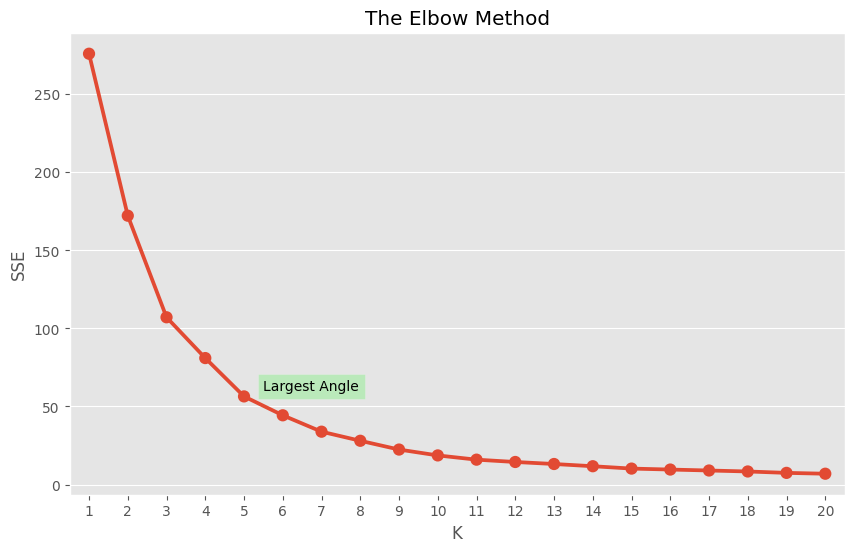

In [37]:
plt.figure(figsize=(10,6))
plt.title('The Elbow Method')

plt.xlabel('K')
plt.ylabel('SSE')
plt.style.use('ggplot')

sns.pointplot(x=list(sse.keys()), y = list(sse.values()))
plt.text(4.5, 60, "Largest Angle", bbox = dict(facecolor = 'lightgreen', alpha = 0.5))
plt.show()

In [38]:
# 5 number of clusters seems good
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(data_normalized)
cluster_labels = kmeans.labels_

data_rfm = data.assign(Cluster = cluster_labels)
data_rfm

,Recency,Frequency,MonetaryValue,Cluster
CUSTOMERNAME,,,,
"AV Stores, Co.",196,51,157807.81,3
Alpha Cognac,65,20,70488.44,0
Amica Models & Co.,265,26,94117.26,0
"Anna's Decorations, Ltd",84,46,153996.13,3
Atelier graphique,188,7,24179.96,2
...,...,...,...,...
"Vida Sport, Ltd",275,31,117713.56,3
Vitachrome Inc.,208,25,88041.26,0
"Volvo Model Replicas, Co",194,19,75754.88,0


Certainly! Let's go through the code line by line:

```python
#Fit KMeans and use elbow method to choose the number of clusters
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
```

1. **Importing Libraries:**
   - `matplotlib.pyplot` and `seaborn`: Used for plotting.
   - `KMeans` from `sklearn.cluster`: Used for performing k-means clustering.

```python
sse = {}

for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data_normalized)
    sse[k] = kmeans.inertia_
```

2. **Elbow Method to Choose the Number of Clusters:**
   - `sse` is a dictionary to store the sum of squared distances (SSE) for each value of k.
   - A loop runs from k=1 to k=20.
   - For each value of k, a k-means model is fitted to the normalized data (`data_normalized`), and the inertia (SSE) is calculated and stored in `sse` dictionary.

```python
plt.figure(figsize=(10, 6))
plt.title('The Elbow Method')
plt.xlabel('K')
plt.ylabel('SSE')
plt.style.use('ggplot')

sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.text(4.5, 60, "Largest Angle", bbox=dict(facecolor='lightgreen', alpha=0.5))
plt.show()
```

3. **Plotting the Elbow Method:**
   - Matplotlib and Seaborn are used to create a point plot to visualize the elbow method.
   - The x-axis represents the number of clusters (k), and the y-axis represents the SSE.
   - A text annotation is added to mark the "elbow" point, where the rate of decrease in SSE slows down.

```python
# 5 number of clusters seems good
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(data_normalized)
cluster_labels = kmeans.labels_

data_rfm = data.assign(Cluster=cluster_labels)
data_rfm
```

4. **Choosing the Optimal Number of Clusters:**
   - Based on the elbow method analysis, the code selects 5 as the optimal number of clusters.
   - A final k-means model is fitted with `n_clusters=5`, and cluster labels are assigned to the original data.
   - The resulting dataframe `data_rfm` includes a new column 'Cluster' indicating the cluster assignment for each data point.

### Explanation:

- **Objective:**
  - The code aims to determine the optimal number of clusters for k-means clustering using the elbow method.

- **Elbow Method:**
  - The elbow method helps in finding the optimal number of clusters by looking for the "elbow" point where the rate of decrease in SSE slows down. This point indicates a good balance between minimizing intra-cluster distance and avoiding overfitting.

- **Visualization:**
  - The point plot provides a visual representation of the SSE for different values of k. The user can identify the elbow point where adding more clusters doesn't significantly reduce the SSE.

- **Cluster Assignment:**
  - After determining the optimal number of clusters (5 in this case), a final k-means model is fitted, and cluster labels are assigned to each data point. The results are stored in the `data_rfm` dataframe.

- **Further Steps:**
  - Depending on the problem and domain knowledge, the analyst may choose the optimal number of clusters for further analysis or segmentation.

In summary, the code demonstrates the elbow method to determine the optimal number of clusters and applies k-means clustering to assign cluster labels to the data points. The resulting clusters can be used for various purposes, such as customer segmentation or pattern recognition.                                                  ### K-Means Clustering:

**Overview:**
K-Means clustering is a partitioning method that divides a dataset into K distinct, non-overlapping subsets (clusters). Each data point belongs to the cluster with the nearest mean, and the algorithm minimizes the sum of squared distances within each cluster. It's widely used due to its simplicity and efficiency.

**Retail Examples:**
1. **Customer Segmentation:**
   - **Application:** Retailers often use K-Means to segment customers based on purchasing behavior, demographics, or transaction history.
   - **Example:** A retail store may identify clusters like "Frequent Shoppers," "Seasonal Buyers," and "One-Time Customers."

2. **Inventory Management:**
   - **Application:** K-Means helps categorize products based on sales patterns, helping optimize inventory levels for different product types.
   - **Example:** Classifying products into clusters like "Fast-Moving," "Slow-Moving," and "Seasonal" for better stocking strategies.

3. **Store Layout Optimization:**
   - **Application:** K-Means can group stores based on sales patterns, helping optimize layout and product placement.
   - **Example:** Identifying clusters of stores with similar customer preferences for targeted marketing or layout adjustments.

4. **Pricing Strategy:**
   - **Application:** Grouping products based on price sensitivity can aid in developing targeted pricing strategies.
   - **Example:** Clustering products into categories like "Premium," "Mid-Range," and "Budget" based on customer preferences.

### Hierarchical Clustering:

**Overview:**
Hierarchical Clustering builds a hierarchy of clusters, either from the top-down (divisive) or bottom-up (agglomerative) approach. It creates a tree-like structure where clusters at one level are merged or split to form clusters at the next level. Dendrogram visualization is often used to represent the hierarchy.

**Retail Examples:**
1. **Market Basket Analysis:**
   - **Application:** Identifying associations between products purchased together helps in optimizing product placement and promotions.
   - **Example:** Grouping products into clusters based on co-purchase patterns to create targeted promotions.

2. **Customer Loyalty Programs:**
   - **Application:** Hierarchical clustering can identify customer segments for personalized loyalty programs.
   - **Example:** Dividing customers into clusters like "Frequent Buyers," "Occasional Shoppers," and "Discount-Driven Customers."

3. **Assortment Planning:**
   - **Application:** Grouping products based on similarities aids in creating well-defined product assortments.
   - **Example:** Clustering products to identify sets that complement each other for strategic product placements.

4. **Geographical Store Planning:**
   - **Application:** Hierarchical clustering can group stores based on geographical proximity and sales similarities.
   - **Example:** Identifying clusters of stores in different regions for customized marketing campaigns and inventory planning.

**Considerations:**
- **K-Means:**
  - Assumes clusters are spherical and equally sized.
  - Faster and suitable for large datasets.

- **Hierarchical Clustering:**
  - Hierarchical structure provides more insights.
  - Suitable for smaller datasets and when cluster shapes are not well-defined.

**Conclusion:**
Both K-Means and Hierarchical Clustering have applications in retail, and the choice depends on the specific problem, data characteristics, and the level of detail desired in cluster exploration.

# **The Explanation of every python library : **

Certainly! Let's go through the libraries used in the provided code snippet and explain their use:

```python
import pandas as pd
import numpy as np
import warnings
```

1. **pandas (`pd`):**
   - **Use:** Pandas is a powerful data manipulation and analysis library. It provides data structures like DataFrame and Series, making it easy to handle and analyze tabular data.
   - **Example Use:** Reading and manipulating datasets, performing data analysis and exploration.

2. **numpy (`np`):**
   - **Use:** NumPy is a library for numerical computations in Python. It provides support for large, multi-dimensional arrays and matrices, along with mathematical functions to operate on these elements efficiently.
   - **Example Use:** Handling numerical operations, working with arrays and matrices.

3. **warnings:**
   - **Use:** The `warnings` module is used to control the display of warning messages.
   - **Example Use:** Suppressing or handling specific warnings during code execution.

```python
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
```

4. **seaborn (`sns`):**
   - **Use:** Seaborn is a statistical data visualization library built on top of Matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.
   - **Example Use:** Creating visually appealing plots for data exploration and analysis.

5. **matplotlib.pyplot (`plt`):**
   - **Use:** Matplotlib is a 2D plotting library, and `pyplot` is a module within Matplotlib for creating static, animated, and interactive visualizations.
   - **Example Use:** Creating various types of plots and visualizations.

6. **pylab:**
   - **Use:** `pylab` is a module within Matplotlib that combines the functionality of NumPy, SciPy, and Matplotlib in a single namespace. It's often used for interactive plotting.
   - **Example Use:** Interactive plotting in certain scenarios.

```python
from sklearn.model_selection import train_test_split
from sklearn import metrics
```

7. **sklearn (`scikit-learn`):**
   - **Use:** Scikit-learn is a machine learning library providing simple and efficient tools for data mining and data analysis.
   - **Example Use:** Splitting datasets into training and testing sets, evaluating model performance.

8. **RandomForestRegressor:**
   - **Use:** RandomForestRegressor is an ensemble learning method for regression that operates by constructing multiple decision trees at training time and outputting the average prediction of the individual trees.
   - **Example Use:** Building and training a random forest regression model.

9. **SVC, LinearSVC (`from sklearn.svm`):**
   - **Use:** Support Vector Machines (SVM) is a set of supervised learning methods for classification and regression tasks. `SVC` is for classification, and `LinearSVC` is a linear SVM classifier.
   - **Example Use:** Building and training SVM models for classification.

10. **KNeighborsClassifier (`from sklearn.neighbors`):**
   - **Use:** KNeighborsClassifier is a classification algorithm based on the k-nearest neighbors algorithm.
   - **Example Use:** Building and training a k-nearest neighbors classifier.

```python
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
```

11. **ColumnTransformer (`from sklearn.compose`):**
   - **Use:** ColumnTransformer applies transformers to columns of an array or pandas DataFrame.
   - **Example Use:** Applying different preprocessing steps to different columns in a dataset.

12. **LabelEncoder, OneHotEncoder, StandardScaler (`from sklearn.preprocessing`):**
   - **Use:**
      - `LabelEncoder`: Encodes categorical labels into numerical values.
      - `OneHotEncoder`: Encodes categorical integer features as a one-hot numeric array.
      - `StandardScaler`: Standardizes features by removing the mean and scaling to unit variance.
   - **Example Use:** Preprocessing steps for preparing data for machine learning models.

```python
from sympy import Symbol, lambdify
```

13. **sympy (`Symbol, lambdify`):**
   - **Use:** Sympy is a library for symbolic mathematics. It provides tools for performing algebraic operations symbolically.
   - **Example Use:** Symbolically representing and manipulating mathematical expressions.

These libraries collectively cover data manipulation, visualization, machine learning, and symbolic mathematics, providing a comprehensive set of tools for various data science and machine learning tasks.